In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
import exercise5
import logging
import exercise6

In [9]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [7]:
def apply_brusselator(u, v, a, b, k):
    u_t = a + k*u**2*v-(b+1)*u
    v_t = b*u - k*u**2*v
    return u_t, v_t

In [4]:
def simulate_brusselator(a, b, k, u0, v0, dt, T):
    num_steps = int(T / dt)
    u = np.zeros(num_steps + 1)
    v = np.zeros(num_steps + 1)
    u[0] = u0
    v[0] = v0

    for t in range(1, num_steps + 1):
        du, dv = apply_brusselator(u[t-1], v[t-1], a, b, k)
        u[t] = u[t-1] + du * dt
        v[t] = v[t-1] + dv * dt

    return u, v

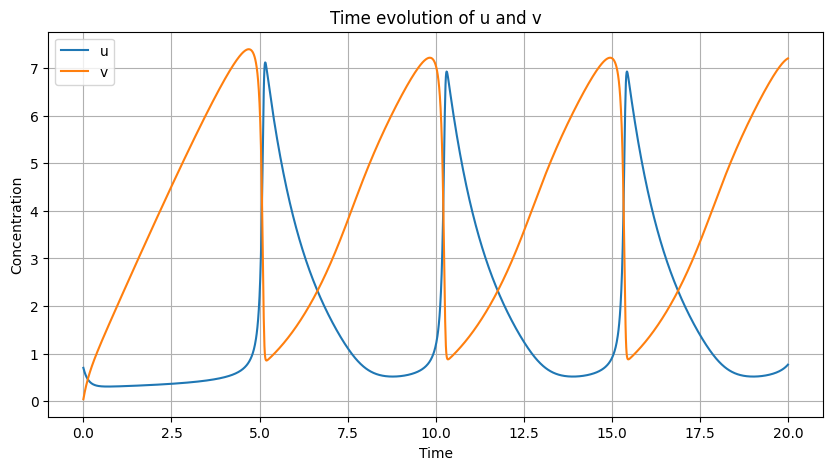

In [5]:
a, b = 2, 6
k = 1
dt = 0.01
T = 20
u0, v0 = 0.7, 0.04
u, v = simulate_brusselator(a, b, k, u0, v0, dt, T)

# Plot the results
time = np.linspace(0, T, int(T / dt) + 1)
plt.figure(figsize=(10, 5))
plt.plot(time, u, label='u')
plt.plot(time, v, label='v')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Time evolution of u and v')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def diffuse(U, D, dx):
    return D * (np.roll(U, 1, axis=0) + np.roll(U, -1, axis=0) +
                np.roll(U, 1, axis=1) + np.roll(U, -1, axis=1) - 4 * U) / (dx**2)

def simulate_brusselator_2d(a, b, k, D, u0, v0, dx, dt, T):
    num_steps = int(T / dt)
    u = u0.copy()
    v = v0.copy()

    frames_dir = "./Exercise7/frames"
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir) 
    
    for t in range(num_steps):
        du, dv = apply_brusselator(u, v, a, b, k)
        u += (du + diffuse(u, D, dx)) * dt
        v += (dv + diffuse(v, D, dx)) * dt
        if t % 5 == 0:  # Save every 10th frame to reduce the number of saved images
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            c1 = axes[0].imshow(u, cmap='viridis', origin='lower')
            axes[0].set_title(f'Concentration of u at t={t*dt:.2f}')
            fig.colorbar(c1, ax=axes[0])
            c2 = axes[1].imshow(v, cmap='viridis', origin='lower')
            axes[1].set_title(f'Concentration of v at t={t*dt:.2f}')
            fig.colorbar(c2, ax=axes[1])
            plt.savefig(f"{frames_dir}/frame_{t:05d}.png")
            plt.close()
        
    return u, v

In [7]:
np.random.seed(123) 
n = 51
D = 10
dx = 81/n
x = np.linspace(0, 81, n)
y = np.linspace(0, 81, n)

X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
T = 10
u0 = np.random.rand(n, n)
v0 = np.random.rand(n, n) + 7

u, v = simulate_brusselator_2d(a, b, k, D, u0, v0, dx, dt, T)


In [4]:
def simulate_brusselator_2d_PSE(a, b, k, D, u0, v0, positions, verlet, epsilon, dt, N, V, T):
    num_steps = int(T / dt)
    u = u0.copy()
    v = v0.copy()

    frames_dir = "./Exercise7/frames_PSE"
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir) 

    for t in range(num_steps):
        logging.info(f'Starting iteration at time {t*dt:.4f}.')
        du, dv = apply_brusselator(u, v, a, b, k)
        u += (du + exercise6.pse_diffusion_2d(D, epsilon, u, positions, verlet, N, V)) * dt
        v += (dv + exercise6.pse_diffusion_2d(D, epsilon, v, positions, verlet, N, V)) * dt
        u = exercise6.periodic_boundaries(u)
        v = exercise6.periodic_boundaries(v)
        if t % 5 == 0: 
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            c1 = axes[0].imshow(u.reshape(n,n), extent = [0, 81, 0 , 81], cmap='viridis', origin='lower')
            axes[0].set_title(f'Concentration of u at t={t*dt:.2f}')
            fig.colorbar(c1, ax=axes[0])
            c2 = axes[1].imshow(v.reshape(n,n), extent = [0, 81, 0 , 81], cmap='viridis', origin='lower')
            axes[1].set_title(f'Concentration of v at t={t*dt:.2f}')
            fig.colorbar(c2, ax=axes[1])
            plt.savefig(f"{frames_dir}/frame_{t:05d}.png")
            plt.close()
        
    return u, v

In [5]:
np.random.seed(123) 
n = 51
D = 10
T = 10
dt = 0.01
a, b = 2, 6
k = 1
l_bound, u_bound = 0, 81
h = (u_bound - l_bound) / ((n*n)**(1/2))
epsilon = h

x = np.linspace(l_bound, u_bound, n)
y = np.linspace(l_bound, u_bound, n)

X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T

u0 = np.random.rand(n, n)
v0 = np.random.rand(n, n) + 7
V = np.ones(n*n)*h**2

cell_side = cutoff = 3*epsilon
particle_matrix, cell_list, num_cells = exercise5.get_cell_list_2d(positions, l_bound, u_bound, cell_side)
verlet = exercise5.get_verlet_list_2d(cell_list, particle_matrix, num_cells, cutoff)

In [10]:
logging.info('Starting 2D diffusion simulation.')
u, v = simulate_brusselator_2d_PSE(
    a, b, k, D, u0.flatten(), v0.flatten(), positions, verlet, epsilon, dt, n*n, V, T
)

In [11]:
def create_video(frames_dir, output_file, fps=10):
    images = []
    for file_name in sorted(os.listdir(frames_dir)):
        if file_name.endswith(".png"):
            file_path = os.path.join(frames_dir, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(output_file, images, fps=fps)

In [12]:
frames_dir = "./Exercise7/frames"
output_file = "./Exercise7/brusselator_simulation.mp4"
create_video(frames_dir, output_file, fps=10)

C:\Users\79217\AppData\Local\Temp\ipykernel_12084\4000624477.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


In [ ]:
frames_dir = "./Exercise7/frames_PSE"
output_file = "./Exercise7/brusselator_simulation_PSE.mp4"
create_video(frames_dir, output_file, fps=10)

C:\Users\79217\AppData\Local\Temp\ipykernel_13008\4000624477.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
2024-07-01 17:45:32,838 - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 500) to (1200, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
